In [1]:
%%time
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
from dataclasses import dataclass
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from dotenv import load_dotenv


@dataclass
class Config:
    project_dir: Path = Path("../../")
    model_dir: Path = project_dir / "models"
    outputs_dir: Path = project_dir / "outputs"
    results_dir: Path = project_dir / "results"
    results_agg_dir: Path = results_dir / "agg"
    results_figs_dir: Path = results_dir / "figs"
    data_dir: Path = project_dir / "data"
    raw_dir: Path = data_dir / "raw"
    interim_dir: Path = data_dir / "interim"
    processed_dir: Path = data_dir / "processed"


config = Config()
sys.path.append(str(config.project_dir.resolve()))
load_dotenv()

CPU times: user 472 ms, sys: 144 ms, total: 616 ms
Wall time: 1.04 s


True

In [2]:
df_order_info_details = pd.read_csv(config.processed_dir / "order_info_details.csv")
df_reviews = pd.read_csv(
    config.interim_dir
    / "olist_order_reviews_translated_label_review_categories_merged.csv",
)
df_reviews_last = df_reviews.groupby("order_id").last().reset_index()
df_order_info_details_reviews_merged = pd.merge(
    df_order_info_details, df_reviews_last, on="order_id", how="left"
)
assert df_order_info_details_reviews_merged.shape[0] == df_order_info_details.shape[0]
for col in [
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date",
    "shipping_limit_date",
]:
    df_order_info_details_reviews_merged[col] = pd.to_datetime(
        df_order_info_details_reviews_merged[col],
        format="mixed",
    )
df_review_no_null = df_order_info_details_reviews_merged.dropna(
    subset=["review_comment_message_en"]
)
print(f"df_review_no_null.shape: {df_review_no_null.shape}")


df_review_no_null.shape: (40818, 90)


In [6]:
low_growth_categories = [
    "watches_gifts",
    "cool_stuff",
    "toys",
    "sports_leisure",
    "bed_bath_table",
    "computers_accessories",
]
df_target = (
    df_review_no_null.query(
        "review_categories_str_modified in ['Delivery_Issue','Delivery_Praise'] "
    )
    .query("customer_state in ['SP','RJ']")
    .query("product_category_name_english in @low_growth_categories")
    .dropna(subset=["order_delivered_customer_span_hours_from_carrier"])
)

df_target["is_same_state"] = (
    df_target["customer_state"] == df_target["seller_state"]
).astype(int)
df_target["is_same_city"] = (
    df_target["customer_city"] == df_target["seller_city"]
).astype(int)


df_target["freight_ratio"] = (
    df_target["sum_freight"] / df_target["sum_price_freight_by_order"]
)
low_growth_categories = [
    "watches_gifts",
    "cool_stuff",
    "toys",
    "sports_leisure",
    "bed_bath_table",
    "computers_accessories",
]

## 全体

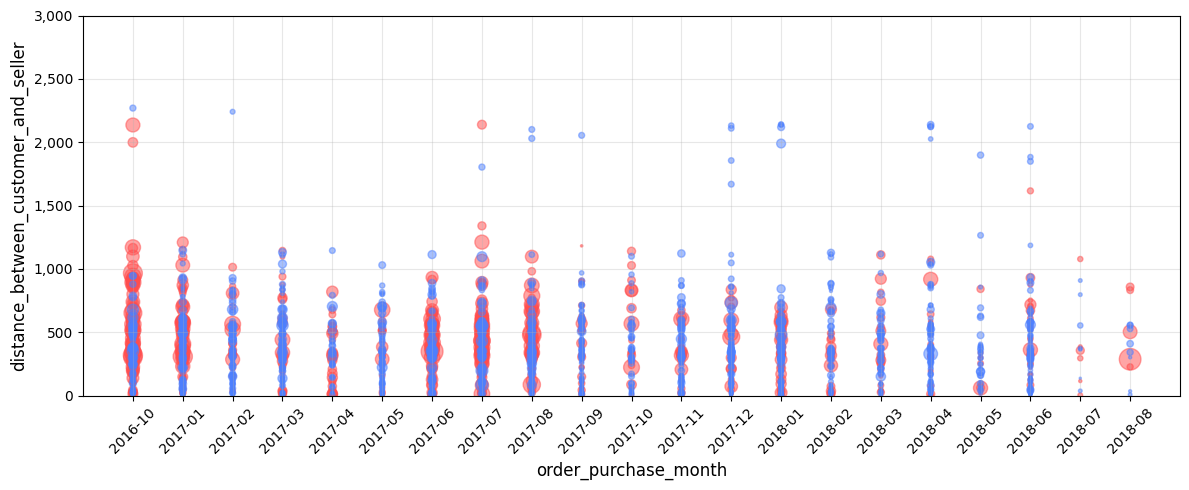

In [44]:
fig, ax = plt.subplots(figsize=(12, 5))

light_blue = (0.3, 0.5, 1.0, 0.6)
light_red = (1.0, 0.3, 0.3, 0.6)
color_map = {"Delivery_Praise": light_blue, "Delivery_Issue": light_red}

# レビューカテゴリごとに散布図をプロット
for category in df_target["review_categories_str_modified"].unique():
    mask = df_target["review_categories_str_modified"] == category
    ax.scatter(
        data=df_target[mask],
        x="order_purchase_month",
        y="distance_between_customer_and_seller",
        s=df_target[mask]["order_delivered_customer_span_hours_from_carrier"]
        .clip(lower=0)
        .fillna(0)
        / 10,
        color=color_map[category],
        alpha=0.5,
        label=category,
    )

ax.set_xlabel("order_purchase_month", fontsize=12)
ax.set_ylabel("distance_between_customer_and_seller", fontsize=12)

x_labels = df_target["order_purchase_month"].unique().astype(str)
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(
    [label if i % 2 == 0 else "" for i, label in enumerate(x_labels)], rotation=45
)
tick_positions = range(len(sorted(df_target["order_purchase_month"].unique())))
tick_labels = sorted(df_target["order_purchase_month"].unique())
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=45)
ax.set_ylim(0, 3000)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{int(x):,}"))
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(
    config.results_figs_dir
    / "delivered_customer_span_hours_from_carrier_span_hour_for_two_factors.png"
)
plt.show()

In [31]:
df_target.sort_values(
    by="order_delivered_customer_span_hours_from_carrier", ascending=False
).to_csv(config.results_agg_dir / "df_target_sorted.csv", index=False)

## 商品カテゴリー別

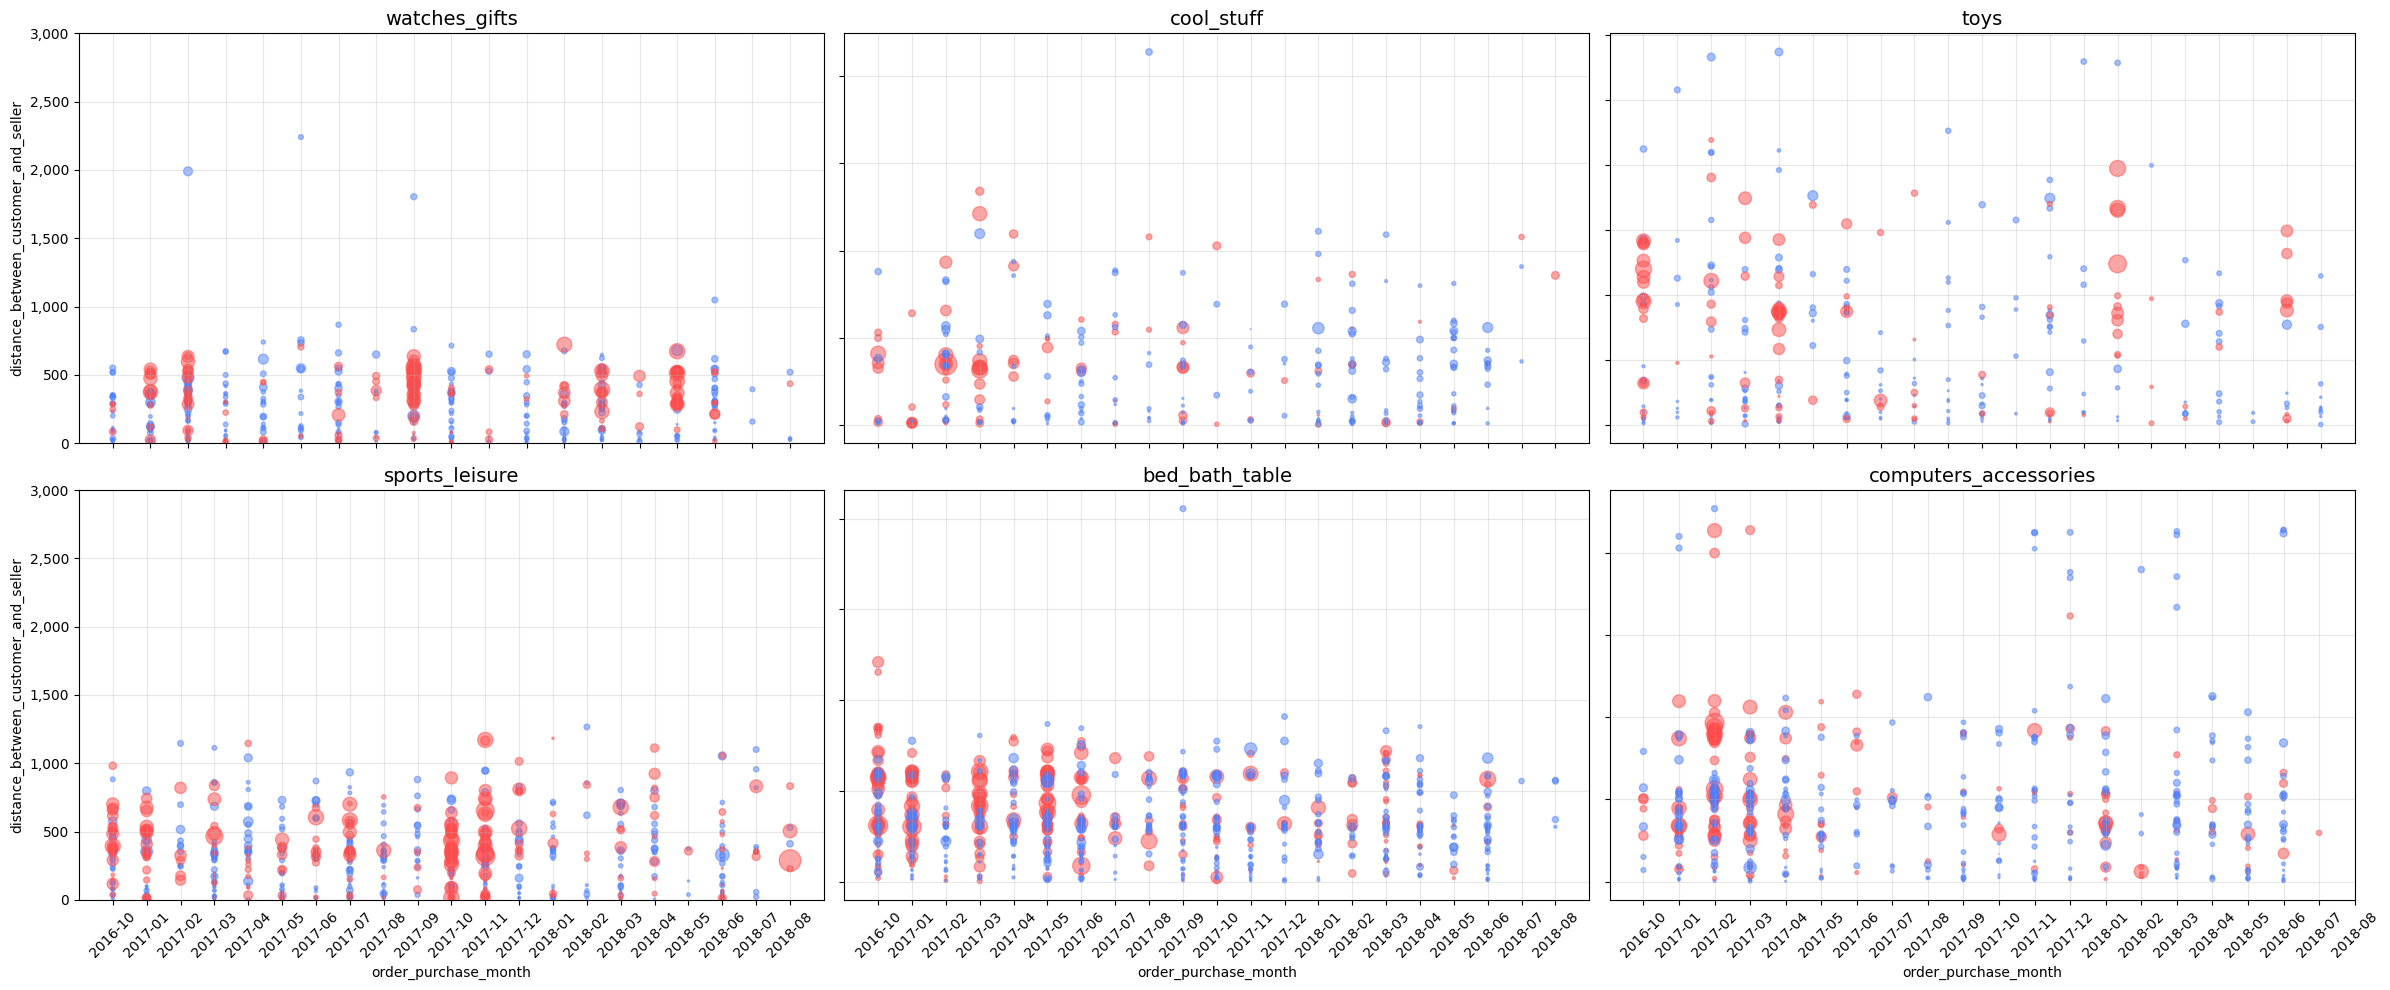

In [45]:
# 2行×3列のサブプロットを作成
fig, axes = plt.subplots(2, 3, figsize=(24, 10))
axes = axes.flatten()  # 2次元配列を1次元に変換して扱いやすくする

light_blue = (0.3, 0.5, 1.0, 0.6)
light_red = (1.0, 0.3, 0.3, 0.6)
color_map = {"Delivery_Praise": light_blue, "Delivery_Issue": light_red}

# 各カテゴリーについてプロット
for idx, category in enumerate(low_growth_categories):
    ax = axes[idx]
    df_target_category = df_target.query("product_category_name_english == @category")
    for review_category in df_target_category[
        "review_categories_str_modified"
    ].unique():
        mask = df_target_category["review_categories_str_modified"] == review_category
        ax.scatter(
            data=df_target_category[mask],
            x="order_purchase_month",
            y="distance_between_customer_and_seller",
            s=df_target_category[mask][
                "order_delivered_customer_span_hours_from_carrier"
            ]
            .clip(lower=0)
            .fillna(0)
            / 10,
            color=color_map[review_category],
            alpha=0.5,
            label=False,
        )

    ax.set_title(f"{category}", fontsize=14)

    # x軸ラベルは最下行（インデックス3, 4, 5）のみに表示
    if idx >= 3:
        ax.set_xlabel("order_purchase_month", fontsize=10)
        tick_positions = range(len(sorted(df_target["order_purchase_month"].unique())))
        tick_labels = sorted(df_target["order_purchase_month"].unique())
        ax.set_xticks(tick_positions)
        ax.set_xticklabels(tick_labels, rotation=45)
        # ax.set_xticklabels(tick_labels, rotation=45)

    else:
        ax.set_xticklabels([])
    # y軸ラベルは最左列（インデックス0, 3）のみに表示
    if idx % 3 == 0:
        ax.set_ylabel("distance_between_customer_and_seller", fontsize=10)
        # y軸の設定
        ax.set_ylim(0, 3000)
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{int(x):,}"))
    else:
        ax.set_yticklabels([])
    ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(
    config.results_figs_dir
    / "delivered_customer_span_hours_from_carrier_span_hour_for_two_factors_each_category.png"
)
plt.show()

category:  watches_gifts


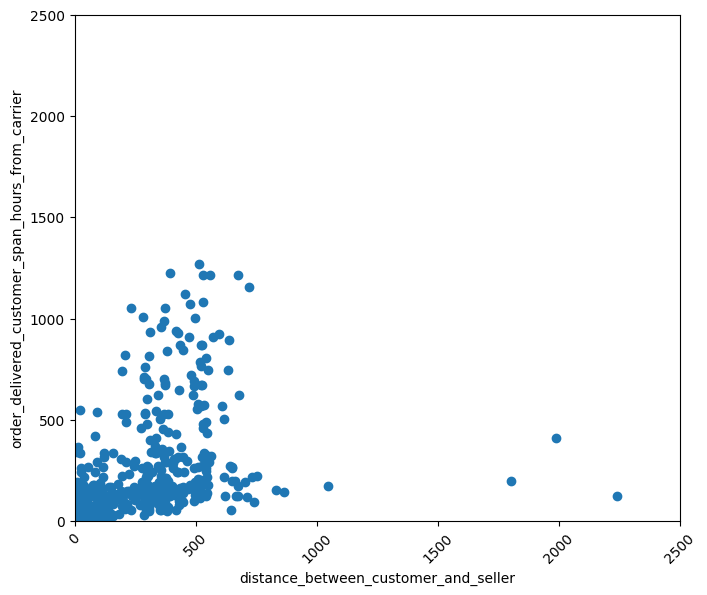

--------------------
category:  cool_stuff


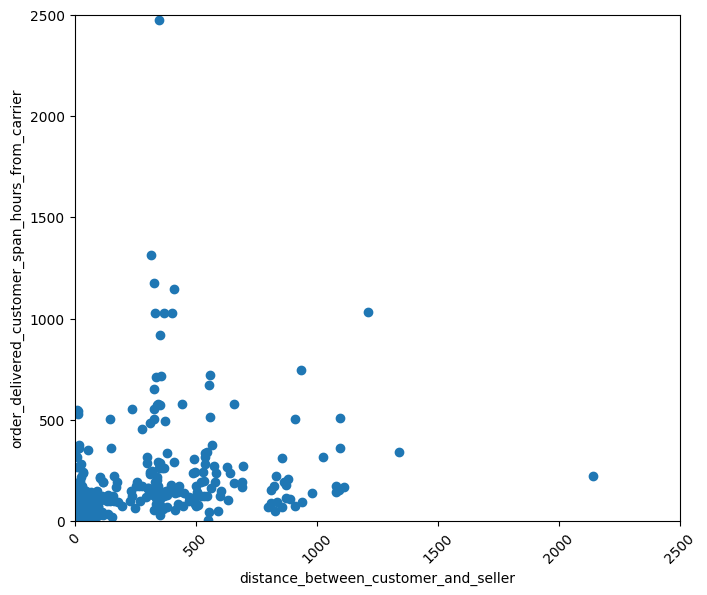

--------------------
category:  toys


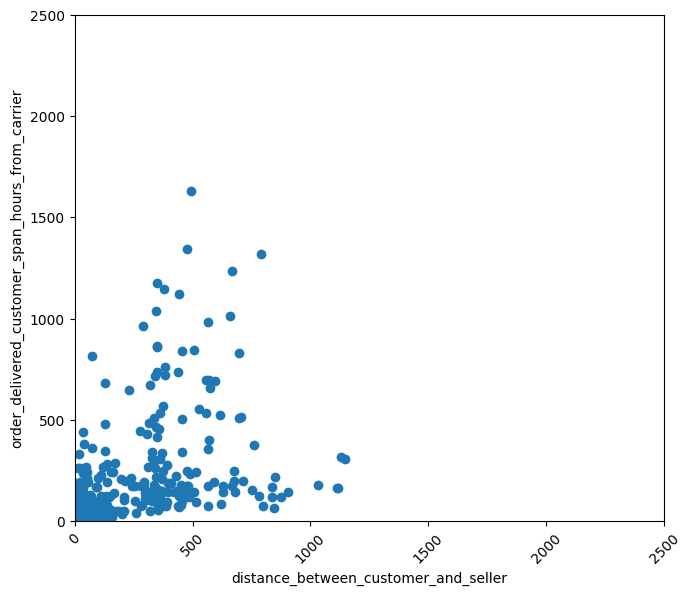

--------------------
category:  sports_leisure


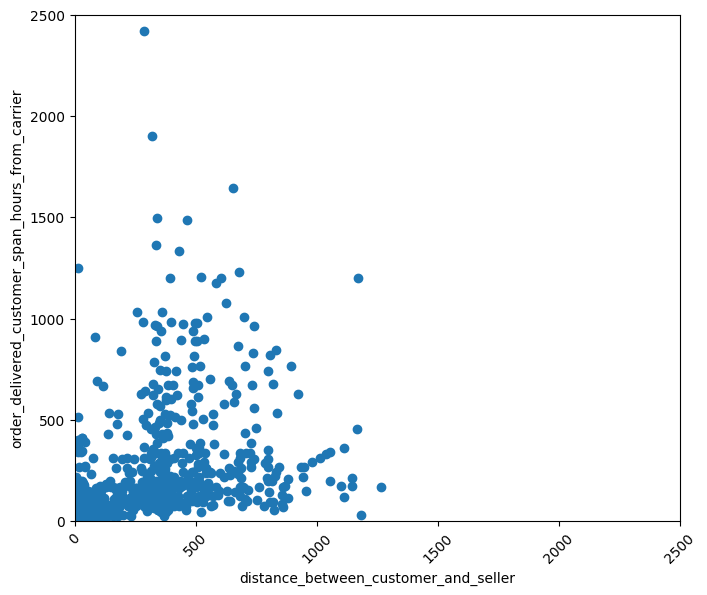

--------------------
category:  bed_bath_table


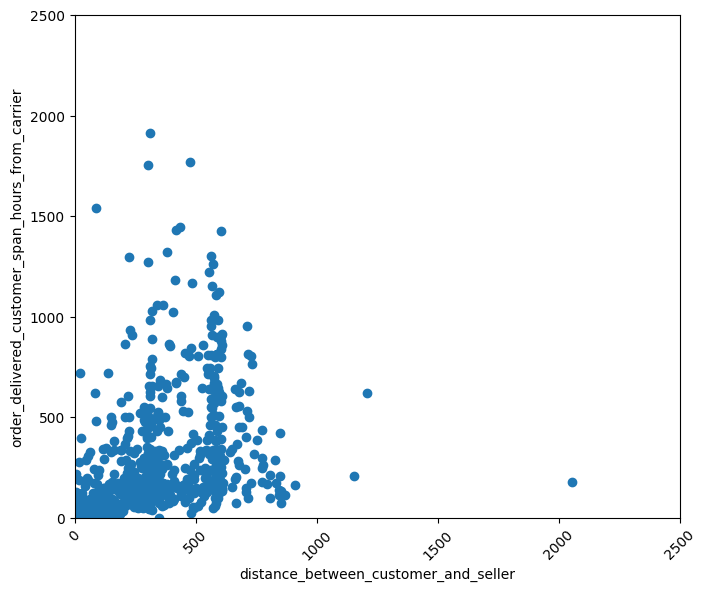

--------------------
category:  computers_accessories


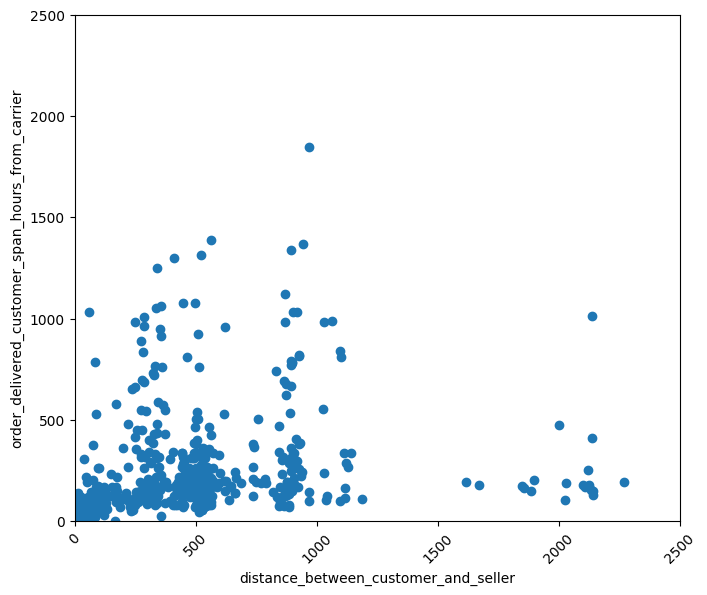

--------------------


In [33]:
low_growth_categories = [
    "watches_gifts",
    "cool_stuff",
    "toys",
    "sports_leisure",
    "bed_bath_table",
    "computers_accessories",
]

for category in low_growth_categories:
    print("category: ", category)
    df_target_category = df_target.query("product_category_name_english == @category")
    # プロットのサイズを設定
    plt.figure(figsize=(7, 6))

    # データをソートして箱ひげ図を作成
    plt.scatter(
        df_target_category["distance_between_customer_and_seller"],
        df_target_category["order_delivered_customer_span_hours_from_carrier"],
    )

    plt.xlabel("distance_between_customer_and_seller")
    plt.ylabel("order_delivered_customer_span_hours_from_carrier")
    plt.xticks(rotation=45)  # x軸のラベルを45度回転

    # 余白を調整
    plt.tight_layout()
    plt.ylim(0, 2500)
    plt.xlim(0, 2500)
    plt.show()
    print("--------------------")

In [56]:
df_target[
    [
        "distance_between_customer_and_seller",
        "order_delivered_customer_span_hours_from_carrier",
    ]
].corr()

,distance_between_customer_and_seller,order_delivered_customer_span_hours_from_carrier
distance_between_customer_and_seller,1.0000,0.2737
order_delivered_customer_span_hours_from_carrier,0.2737,1.0000


<Axes: xlabel='order_estimated_delivery_span_hours_from_carrier', ylabel='order_delivered_customer_span_hours_from_carrier'>

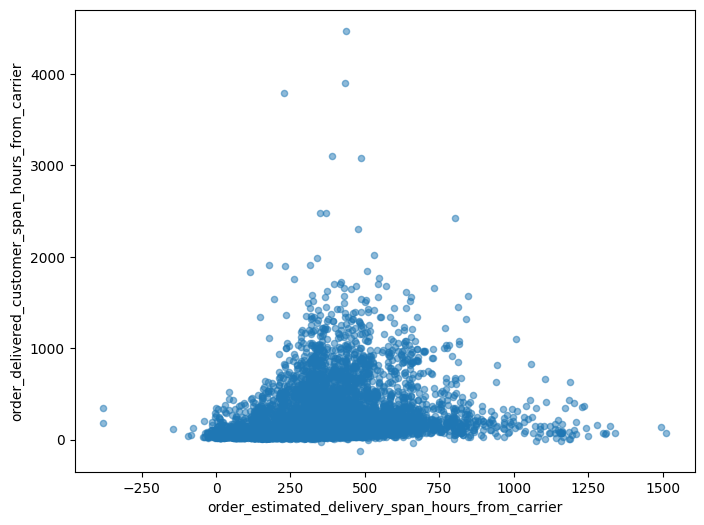

In [66]:
df_target.plot.scatter(
    x="order_estimated_delivery_span_hours_from_carrier",
    y="order_delivered_customer_span_hours_from_carrier",
    figsize=(8, 6),
    alpha=0.5,
)